<a href="https://colab.research.google.com/github/Ianfm94/Dissertation/blob/master/Notebooks/5a.%20Final_Model_tanh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downloading Required packages for SMOTE & Saving LSTM

#%pip install imbalanced-learn
#%pip install h5py

# Importing required packages
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import pandas as pd
import numpy as np
from numpy import array
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Softmax
from keras.layers import RepeatVector, BatchNormalization, TimeDistributed
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.metrics import Precision, Recall, AUC, Accuracy
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import imblearn

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
import seaborn as sns

from google.colab import  drive
drive.mount('/drive', force_remount=True)

print(tf.__version__)
print(imblearn.__version__)

Mounted at /drive
2.3.0
0.4.3


Frequency of Volatility: 388558
Frequency of Jumps: 1442

Positive Class %: 0.37
Negative Class %: 99.63


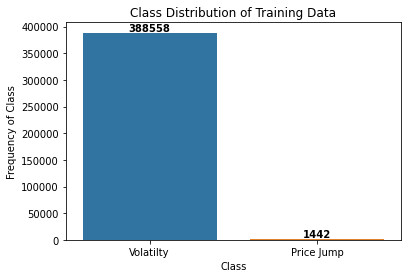


     Return  Sequence
0  0.709546         0
1 -0.102007         1
2 -0.013313         2
3  0.042152         3
4  0.152927         4
5  0.035428         5
6 -0.105214         6
7  0.313100         7
8 -0.083987         8
9 -0.080738         9
(390000, 2)

     Return  Sequence
0 -0.288097         0
1 -0.549686         1
2 -0.465252         2
3 -0.029156         3
4  0.639355         4
5  0.217032         5
6  0.245396         6
7  0.517974         7
8  0.100066         8
9  0.157492         9
(19500, 2)

   Sequence  Label
0         0      0
1         1      0
2         2      0
3         3      0
4         4      0
5         5      0
6         6      0
7         7      0
8         8      0
9         9      0
(19500, 2)


In [ ]:
# Reading in training and Combined data
train = pd.read_csv('Log_Training_Data_Distribution.csv',
                    index_col = 0)
train = pd.DataFrame(train)

test = pd.read_csv('Log_Test_Data_Distribution.csv',
                   index_col = 0)
test = pd.DataFrame(test)

SMOTE_Combined = pd.read_csv('SMOTE_Log_Training_Data.csv',
                             index_col = 0)
SMOTE_Combined = pd.DataFrame(SMOTE_Combined)

# Plotting Class Imbalance in Data

class_, frequency = np.unique(train.Label, return_counts=True)
labels_data = dict(zip(class_, frequency))
print('Frequency of Volatility:', labels_data[0])
print('Frequency of Jumps:', labels_data[1])
print()

neg, pos = labels_data[0], labels_data[1]
comb = labels_data[0] + labels_data[1]
pos_class, neg_class = pos / comb, neg / comb
pos_class, neg_class = round(pos_class * 100, 2), round(neg_class * 100, 2)

print('Positive Class %:', pos_class)
print('Negative Class %:', neg_class)

sns.barplot(list(labels_data.keys()), list(labels_data.values()))

plt.title('Class Distribution of Training Data')
plt.ylabel('Frequency of Class')

plt.xlabel('Class')
plt.xticks(ticks=class_, labels = ['Volatilty', 'Price Jump'])

for i, v in enumerate(frequency):
    plt.text(i, v, s=str(v), color='black',
             fontweight='bold', ha='center', va='bottom')
plt.show()

# Removing Time Column
train.drop(train.columns[-2], axis=1, inplace=True)

# Separating Labels 
y = train.Label

# Removing Label Column
train.drop(train.columns[-2], axis=1, inplace=True)
train = pd.DataFrame(train)

# Removing Time Column
test.drop(test.columns[-3], axis=1, inplace=True)
test = pd.DataFrame(test)

# Separating Labels & Removing Time & Return
ytest = pd.DataFrame(test)
ytest.drop(test.columns[-3], axis=1, inplace=True)
ytest = pd.DataFrame(ytest)

# Removing Label Column
test.drop(test.columns[-1], axis=1, inplace=True)
test = pd.DataFrame(test)

print()
print(train.head(n=10))
print(train.shape)
print()
print(test.head(n=10))
print(test.shape)
print()
print(ytest.head(n=10))
print(ytest.shape)

In [ ]:
np.random.seed(111)

x_train, x_valid, y_train, y_valid, = train_test_split(train, y,
    test_size=0.25, random_state=111)

print("Number transactions x_train dataset: ", x_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions x_test dataset: ", x_valid.shape) 
print("Number transactions y_test dataset: ", y_valid.shape) 
print()
print("Before SMOTE, counts of Price Jumps in Training Data: {}".format(sum(y_train == 1))) 
print("Before SMOTE, counts of Volatility in Training Data: {} \n".format(sum(y_train == 0))) 
print("Before SMOTE, total count in Training Data: {} \n".format(sum(y_train == 0) + sum(y_train == 1)))  

print("Before SMOTE, counts of Price Jumps in Validation Data: {}".format(sum(y_valid == 1))) 
print("Before SMOTE, counts of Volatility in Validation Data: {} \n".format(sum(y_valid == 0))) 
print("Before SMOTE, total count in Validation Data: {} \n".format(sum(y_valid == 0) + sum(y_valid == 1)))  


Number transactions x_train dataset:  (292500, 2)
Number transactions y_train dataset:  (292500,)
Number transactions x_test dataset:  (97500, 2)
Number transactions y_test dataset:  (97500,)

Before SMOTE, counts of Price Jumps in Training Data: 1085
Before SMOTE, counts of Volatility in Training Data: 291415 

Before SMOTE, total count in Training Data: 292500 

Before SMOTE, counts of Price Jumps in Validation Data: 357
Before SMOTE, counts of Volatility in Validation Data: 97143 

Before SMOTE, total count in Validation Data: 97500 



In [ ]:
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
x_train, y_train = pipeline.fit_resample(x_train, y_train)
x_valid, y_valid = pipeline.fit_resample(x_valid, y_valid)
print()

print('After SMOTE, the shape of x_train_1: {}'.format(x_train.shape)) 
print('After SMOTE, the shape of y_train_1: {} \n'.format(y_train.shape))
print('After SMOTE, the shape of x_valid_1: {}'.format(x_valid.shape)) 
print('After SMOTE, the shape of y_valid_1: {} \n'.format(y_valid.shape))
 
print("After SMOTE, counts of Price Jumps in Training Data: {}".format(sum(y_train == 1))) 
print("After SMOTE, counts of Volatility in Training Data: {}".format(sum(y_train == 0))) 
print("After SMOTE, total count in Training Data: {} \n".format(sum(y_train == 0) + sum(y_train == 1)))

print("After SMOTE, counts of Price Jumps in Validation Data: {}".format(sum(y_valid == 1))) 
print("After SMOTE, counts of Volatility in Validation Data: {}".format(sum(y_valid == 0))) 
print("After SMOTE, total count in Validation Data: {} \n".format(sum(y_valid == 0) + sum(y_valid == 1)))

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_valid = pd.DataFrame(x_valid)
y_valid = pd.DataFrame(y_valid)


After SMOTE, the shape of x_train_1: (87423, 2)
After SMOTE, the shape of y_train_1: (87423,) 

After SMOTE, the shape of x_valid_1: (29142, 2)
After SMOTE, the shape of y_valid_1: (29142,) 

After SMOTE, counts of Price Jumps in Training Data: 29141
After SMOTE, counts of Volatility in Training Data: 58282
After SMOTE, total count in Training Data: 87423 

After SMOTE, counts of Price Jumps in Validation Data: 9714
After SMOTE, counts of Volatility in Validation Data: 19428
After SMOTE, total count in Validation Data: 29142 



In [ ]:
# Reshaping data into 3d format for LSTM input

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test  = np.array(test)
y_test  = np.array(ytest)

n_samples_train = x_train.shape[0]
n_samples_valid = x_valid.shape[0]
n_samples_test =  x_test.shape[0]
n_timesteps = 2
n_timesteps_x =  x_train.shape[1]
n_timesteps_y =  y_train.shape[1]
n_timesteps_t =  x_test.shape[1]
n_timesteps_yt = y_test.shape[0]
n_features = 1

x_train = np.reshape(x_train, (n_samples_train, n_timesteps_x, n_features))
x_valid = np.reshape(x_valid, (n_samples_valid, n_timesteps_x, n_features))
y_train = np.reshape(y_train, (n_samples_train, n_timesteps_y, n_features))
y_valid = np.reshape(y_valid, (n_samples_valid, n_timesteps_y, n_features))
x_test =  np.reshape(x_test,  (n_samples_test,  n_timesteps_t, n_features))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

Frequency of Volatility: 77710
Frequency of Jumps: 38855

Positive Class %: 33.33
Negative Class %: 66.67


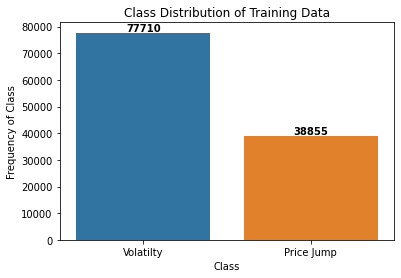

In [ ]:
# Plotting Class Imbalance after SMOTE

class_, frequency = np.unique(SMOTE_Combined.Label, return_counts=True)
labels_data = dict(zip(class_, frequency))
print('Frequency of Volatility:', labels_data[0])
print('Frequency of Jumps:', labels_data[1])
print()

neg, pos = labels_data[0], labels_data[1]
comb = labels_data[0] + labels_data[1]
pos_class, neg_class = pos / comb, neg / comb
pos_class, neg_class = round(pos_class * 100, 2), round(neg_class * 100, 2)

print('Positive Class %:', pos_class)
print('Negative Class %:', neg_class)

sns.barplot(list(labels_data.keys()), list(labels_data.values()))

plt.title('Class Distribution of Training Data')
plt.ylabel('Frequency of Class')

plt.xlabel('Class')
plt.xticks(ticks=class_, labels = ['Volatilty', 'Price Jump'])

for i, v in enumerate(frequency):
    plt.text(i, v, s=str(v), color='black',
             fontweight='bold', ha='center', va='bottom')
plt.show()

In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1 = Sequential()
ac_model_1.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1.add(LSTM(150))
ac_model_1.add(Dropout(0.2))

ac_model_1.add(RepeatVector(n_timesteps))

ac_model_1.add(LSTM(150, return_sequences = True))
ac_model_1.add(Dropout(0.2))
ac_model_1.add(LSTM(200, return_sequences = True))
ac_model_1.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1.compile(loss='binary_crossentropy', optimizer='SGD', 
                 metrics=['accuracy'])

results_ac_model_1 = ac_model_1.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1.summary())

ac_model_1.save('lstm_model.h5')

Epoch 1/100
2732/2732 [==============================] - 47s 17ms/step - loss: 0.8163 - accuracy: 0.5344 - val_loss: 0.6263 - val_accuracy: 0.4833
Epoch 2/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.6239 - accuracy: 0.5462 - val_loss: 0.6224 - val_accuracy: 0.4991
Epoch 3/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.6213 - accuracy: 0.5602 - val_loss: 0.6203 - val_accuracy: 0.4910
Epoch 4/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.6195 - accuracy: 0.5645 - val_loss: 0.6187 - val_accuracy: 0.5140
Epoch 5/100
2732/2732 [==============================] - 43s 16ms/step - loss: 0.6184 - accuracy: 0.5659 - val_loss: 0.6173 - val_accuracy: 0.5129
Epoch 6/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.6173 - accuracy: 0.5639 - val_loss: 0.6169 - val_accuracy: 0.5130
Epoch 7/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.6168 - accuracy: 0.5580 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 69.0 %
Validation-Accuracy: 68.51 %


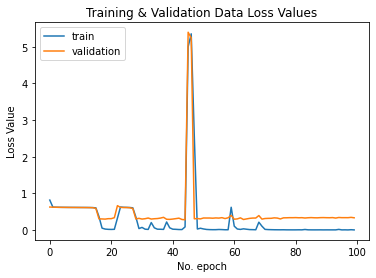

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1.history['loss'], label='train')
plt.plot(results_ac_model_1.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

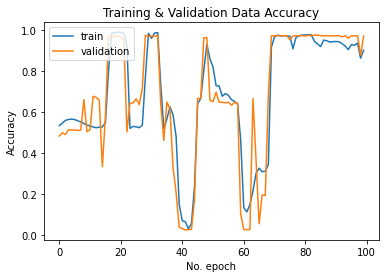

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1.history['accuracy'], label='train')
plt.plot(results_ac_model_1.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_150_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

[[19491     1]
 [    0     8]]

Overall Accuracy: 99.9949 %
Overall Precision: 88.89 %
Overall Recall: 100.0 %
Overall F1 Score: 0.9411764705882353


In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1b = Sequential()
ac_model_1b.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1b.add(LSTM(100))
ac_model_1b.add(Dropout(0.2))

ac_model_1b.add(RepeatVector(n_timesteps))

ac_model_1b.add(LSTM(100, return_sequences = True))
ac_model_1b.add(Dropout(0.2))
ac_model_1b.add(LSTM(200, return_sequences = True))
ac_model_1b.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1b.compile(loss='binary_crossentropy', optimizer='Adamax', 
                 metrics=['accuracy'])

results_ac_model_1b = ac_model_1b.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1b.summary())

ac_model_1b.save('lstm_model_adamax.h5')


Epoch 1/100
2732/2732 [==============================] - 47s 17ms/step - loss: 0.1846 - accuracy: 0.7727 - val_loss: 0.3307 - val_accuracy: 0.8443
Epoch 2/100
2732/2732 [==============================] - 45s 17ms/step - loss: 0.0110 - accuracy: 0.8086 - val_loss: 0.3320 - val_accuracy: 0.7940
Epoch 3/100
2732/2732 [==============================] - 45s 17ms/step - loss: 0.0095 - accuracy: 0.7881 - val_loss: 0.3177 - val_accuracy: 0.9105
Epoch 4/100
2732/2732 [==============================] - 46s 17ms/step - loss: 0.0068 - accuracy: 0.8407 - val_loss: 0.3367 - val_accuracy: 0.8161
Epoch 5/100
2732/2732 [==============================] - 46s 17ms/step - loss: 0.0069 - accuracy: 0.8470 - val_loss: 0.3197 - val_accuracy: 0.9377
Epoch 6/100
2732/2732 [==============================] - 46s 17ms/step - loss: 0.0060 - accuracy: 0.8374 - val_loss: 0.3414 - val_accuracy: 0.8409
Epoch 7/100
2732/2732 [==============================] - 46s 17ms/step - loss: 0.0075 - accuracy: 0.8176 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1b.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1b.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 83.5 %
Validation-Accuracy: 81.65 %


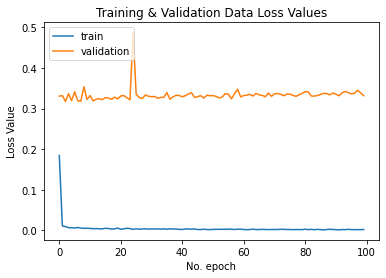

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1b.history['loss'], label='train')
plt.plot(results_ac_model_1b.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

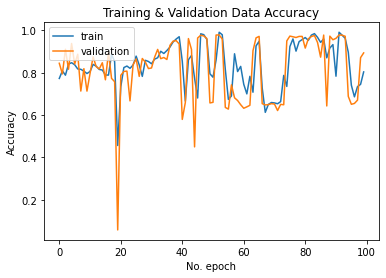

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1b.history['accuracy'], label='train')
plt.plot(results_ac_model_1b.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_adamax_200_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
#y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

[[19491     1]
 [    0     8]]

Overall Accuracy: 99.9949 %
Overall Precision: 88.89 %
Overall Recall: 100.0 %
Overall F1 Score: 0.9411764705882353


In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1c = Sequential()
ac_model_1c.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1c.add(LSTM(100))
ac_model_1c.add(Dropout(0.2))

ac_model_1c.add(RepeatVector(n_timesteps))

ac_model_1c.add(LSTM(100, return_sequences = True))
ac_model_1c.add(Dropout(0.2))
ac_model_1c.add(LSTM(200, return_sequences = True))
ac_model_1c.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1c.compile(loss='binary_crossentropy', optimizer='Adam', 
                 metrics=['accuracy'])

results_ac_model_1c = ac_model_1c.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1c.summary())

ac_model_1c.save('lstm_model_tanh_adam_200_17_08.h5')


Epoch 1/100
2732/2732 [==============================] - 44s 16ms/step - loss: 0.0631 - accuracy: 0.3618 - val_loss: 0.3106 - val_accuracy: 0.2420
Epoch 2/100
2732/2732 [==============================] - 42s 15ms/step - loss: 0.0118 - accuracy: 0.7183 - val_loss: 0.3145 - val_accuracy: 0.9666
Epoch 3/100
2732/2732 [==============================] - 42s 15ms/step - loss: 0.0150 - accuracy: 0.5226 - val_loss: 0.3137 - val_accuracy: 0.3344
Epoch 4/100
2732/2732 [==============================] - 42s 15ms/step - loss: 0.0102 - accuracy: 0.4524 - val_loss: 0.3062 - val_accuracy: 0.0694
Epoch 5/100
2732/2732 [==============================] - 42s 15ms/step - loss: 0.0141 - accuracy: 0.2473 - val_loss: 0.3214 - val_accuracy: 0.3167
Epoch 6/100
2732/2732 [==============================] - 42s 15ms/step - loss: 0.0074 - accuracy: 0.2848 - val_loss: 0.3227 - val_accuracy: 0.0557
Epoch 7/100
2732/2732 [==============================] - 43s 16ms/step - loss: 0.0056 - accuracy: 0.3089 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1c.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1c.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 46.25 %
Validation-Accuracy: 45.64 %


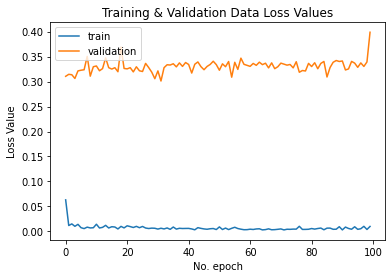

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1c.history['loss'], label='train')
plt.plot(results_ac_model_1c.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

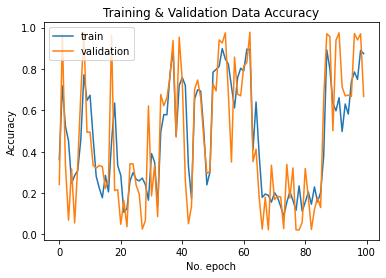

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1c.history['accuracy'], label='train')
plt.plot(results_ac_model_1c.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_adam_200_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
#y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

[[    6 19486]
 [    0     8]]

Overall Accuracy: 0.0718 %
Overall Precision: 0.04 %
Overall Recall: 100.0 %
Overall F1 Score: 0.0008204286739821557


In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1d = Sequential()
ac_model_1d.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1d.add(LSTM(100))
ac_model_1d.add(Dropout(0.2))

ac_model_1d.add(RepeatVector(n_timesteps))

ac_model_1d.add(LSTM(100, return_sequences = True))
ac_model_1d.add(Dropout(0.2))
ac_model_1d.add(LSTM(200, return_sequences = True))
ac_model_1d.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1d.compile(loss='binary_crossentropy', optimizer='SGD', 
                 metrics=['accuracy'])

results_ac_model_1d = ac_model_1d.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1d.summary())

ac_model_1d.save('lstm_model_tanh_sgd_200_17_08.h5')


Epoch 1/100
2732/2732 [==============================] - 42s 16ms/step - loss: 0.6553 - accuracy: 0.5328 - val_loss: 0.6285 - val_accuracy: 0.5000
Epoch 2/100
2732/2732 [==============================] - 41s 15ms/step - loss: 0.6250 - accuracy: 0.5593 - val_loss: 0.6227 - val_accuracy: 0.6328
Epoch 3/100
2732/2732 [==============================] - 41s 15ms/step - loss: 0.6213 - accuracy: 0.5518 - val_loss: 0.6199 - val_accuracy: 0.4840
Epoch 4/100
2732/2732 [==============================] - 40s 15ms/step - loss: 0.6194 - accuracy: 0.5485 - val_loss: 0.6181 - val_accuracy: 0.4714
Epoch 5/100
2732/2732 [==============================] - 41s 15ms/step - loss: 0.6181 - accuracy: 0.5403 - val_loss: 0.6168 - val_accuracy: 0.4951
Epoch 6/100
2732/2732 [==============================] - 41s 15ms/step - loss: 0.6178 - accuracy: 0.5357 - val_loss: 0.6160 - val_accuracy: 0.6199
Epoch 7/100
2732/2732 [==============================] - 41s 15ms/step - loss: 0.6171 - accuracy: 0.5314 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1d.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1d.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 41.26 %
Validation-Accuracy: 41.79 %


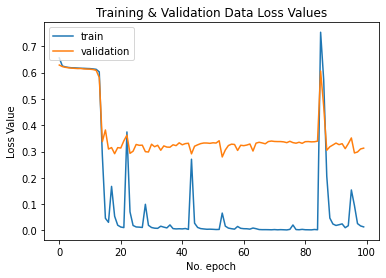

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1d.history['loss'], label='train')
plt.plot(results_ac_model_1d.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

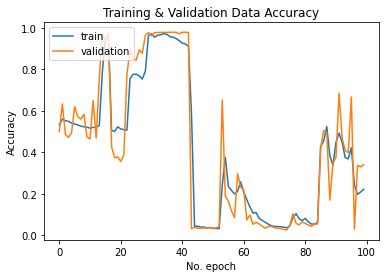

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1d.history['accuracy'], label='train')
plt.plot(results_ac_model_1d.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_sgd_200_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
#y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1e = Sequential()
ac_model_1e.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1e.add(LSTM(125))
ac_model_1e.add(Dropout(0.2))

ac_model_1e.add(RepeatVector(n_timesteps))

ac_model_1e.add(LSTM(125, return_sequences = True))
ac_model_1e.add(Dropout(0.2))
ac_model_1e.add(LSTM(200, return_sequences = True))
ac_model_1e.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1e.compile(loss='binary_crossentropy', optimizer='SGD', 
                 metrics=['accuracy'])

results_ac_model_1e = ac_model_1e.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1e.summary())

ac_model_1e.save('lstm_model_tanh_sgd_125_17_08.h5')


Epoch 1/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.6475 - accuracy: 0.4854 - val_loss: 0.6284 - val_accuracy: 0.5000
Epoch 2/100
2732/2732 [==============================] - 28s 10ms/step - loss: 0.6248 - accuracy: 0.5326 - val_loss: 0.6227 - val_accuracy: 0.5177
Epoch 3/100
2732/2732 [==============================] - 29s 10ms/step - loss: 0.6213 - accuracy: 0.5232 - val_loss: 0.6207 - val_accuracy: 0.7315
Epoch 4/100
2732/2732 [==============================] - 28s 10ms/step - loss: 0.6194 - accuracy: 0.5084 - val_loss: 0.6184 - val_accuracy: 0.3345
Epoch 5/100
2732/2732 [==============================] - 28s 10ms/step - loss: 0.6181 - accuracy: 0.4921 - val_loss: 0.6172 - val_accuracy: 0.5548
Epoch 6/100
2732/2732 [==============================] - 28s 10ms/step - loss: 0.6176 - accuracy: 0.4871 - val_loss: 0.6162 - val_accuracy: 0.3307
Epoch 7/100
2732/2732 [==============================] - 28s 10ms/step - loss: 0.6168 - accuracy: 0.4852 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1e.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1e.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 38.91 %
Validation-Accuracy: 43.69 %


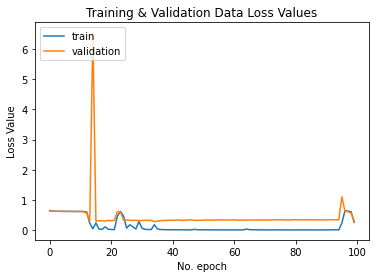

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1e.history['loss'], label='train')
plt.plot(results_ac_model_1e.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

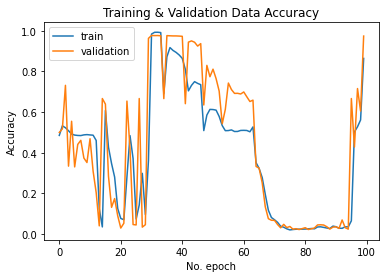

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1e.history['accuracy'], label='train')
plt.plot(results_ac_model_1e.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_sgd_125_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
#y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

[[19398    94]
 [    0     8]]

Overall Accuracy: 99.5179 %
Overall Precision: 7.84 %
Overall Recall: 100.0 %
Overall F1 Score: 0.14545454545454545


In [ ]:
# LSTM Workings_Autoencoder Model

ac_model_1f = Sequential()
ac_model_1f.add(Bidirectional(LSTM(units=200, return_sequences = True,
                               input_shape = (n_timesteps, n_features), 
                                kernel_initializer='glorot_normal')))
ac_model_1f.add(LSTM(175))
ac_model_1f.add(Dropout(0.2))

ac_model_1f.add(RepeatVector(n_timesteps))

ac_model_1f.add(LSTM(175, return_sequences = True))
ac_model_1f.add(Dropout(0.2))
ac_model_1f.add(LSTM(200, return_sequences = True))
ac_model_1f.add(TimeDistributed(Dense(2, activation='tanh')))

ac_model_1f.compile(loss='binary_crossentropy', optimizer='Adamax', 
                 metrics=['accuracy'])

results_ac_model_1f = ac_model_1f.fit(x_train, y_train, epochs=100, batch_size=32,
                        shuffle=True, validation_data=(x_valid, y_valid))

print(ac_model_1f.summary())

ac_model_1f.save('lstm_model_tanh_adamax_175_17_08.h5')


Epoch 1/100
2732/2732 [==============================] - 30s 11ms/step - loss: 0.1016 - accuracy: 0.7258 - val_loss: 0.3318 - val_accuracy: 0.6780
Epoch 2/100
2732/2732 [==============================] - 30s 11ms/step - loss: 0.0081 - accuracy: 0.5500 - val_loss: 0.3226 - val_accuracy: 0.1256
Epoch 3/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.0071 - accuracy: 0.0859 - val_loss: 0.3495 - val_accuracy: 0.1212
Epoch 4/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.0077 - accuracy: 0.2522 - val_loss: 0.3192 - val_accuracy: 0.1517
Epoch 5/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.0065 - accuracy: 0.5061 - val_loss: 0.3301 - val_accuracy: 0.8779
Epoch 6/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.0073 - accuracy: 0.8538 - val_loss: 0.3118 - val_accuracy: 0.9096
Epoch 7/100
2732/2732 [==============================] - 29s 11ms/step - loss: 0.0061 - accuracy: 0.8714 - val_loss: 0

In [ ]:
# Performance Metrcs

Train_Acc = np.mean(results_ac_model_1f.history["accuracy"]) * 100
Train_Acc = round(Train_Acc, 2)
Valid_Acc = np.mean(results_ac_model_1f.history["val_accuracy"]) * 100
Valid_Acc = round(Valid_Acc, 2)

print("Training-Accuracy:", Train_Acc, '%')
print("Validation-Accuracy:", Valid_Acc, '%') 


Training-Accuracy: 62.05 %
Validation-Accuracy: 62.49 %


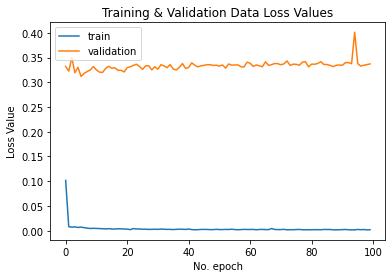

In [ ]:
# plot loss during training

plt.title('Training & Validation Data Loss Values')
plt.plot(results_ac_model_1f.history['loss'], label='train')
plt.plot(results_ac_model_1f.history['val_loss'], label='validation')
plt.ylabel('Loss Value')    
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

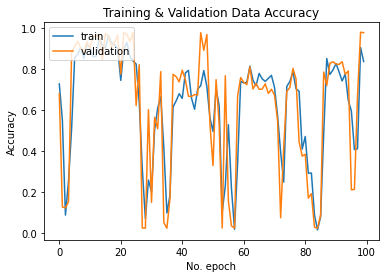

In [ ]:
# plot accuracy during training

plt.title('Training & Validation Data Accuracy')
plt.plot(results_ac_model_1f.history['accuracy'], label='train')
plt.plot(results_ac_model_1f.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# load model from single file
model = load_model('/drive/My Drive/Colab Notebooks/Dissertation Workings/CSV Files/lstm_model_tanh_adamax_175_17_08.h5')

y_pred = model.predict(x_test)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = pd.DataFrame(y_pred_bool)
y_pred_bool.drop(y_pred_bool.columns[-2], axis=1, inplace=True)
y_pred_bool = pd.DataFrame(y_pred_bool)

y_test = pd.DataFrame(y_test)
y_test.drop(y_test.columns[-2], axis=1, inplace=True)
y_test = pd.DataFrame(y_test)

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_bool)
print(cm)

# Print f1, precision, and recall scores

acc = accuracy_score(y_test, y_pred_bool)
acc = acc * 100
acc = round(acc, 4)
prec = precision_score(y_test, y_pred_bool , average="binary")
prec = prec * 100
prec = round(prec, 2)
rec  = recall_score(y_test, y_pred_bool , average="binary")
rec  = rec * 100
rec  = round(rec, 2)
f1   = f1_score(y_test, y_pred_bool , average="binary")

print()
print('Overall Accuracy:',  acc,  '%')
print('Overall Precision:', prec, '%')
print('Overall Recall:',    rec,  '%')
print('Overall F1 Score:',   f1)

[[19491     1]
 [    0     8]]

Overall Accuracy: 99.9949 %
Overall Precision: 88.89 %
Overall Recall: 100.0 %
Overall F1 Score: 0.9411764705882353


Clearly, the best model is 1b. The Adamax optimizer with tanh.